CODE BLOCK: 1

### Import Heavenly Gods ( Import libraries )

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

### Check if cuda is available

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

### Define train and test data transformations
*  ***transforms.Compose*** - compose list of transforms together / chain multiple transformations
* ***transforms.RandomApply*** - randomly apply listed transformation based on probability / introduces random variation into data to make model robust and  generalize unseen data / data augmentation / increase variability ( prevent overfitting )
* ***transforms.CenterCrop*** - extract square or crop from center of image ( size = 22 / side length)
* ***transforms.Resize*** - resize image to specific size
* ***transforms.RandomRotation*** - rotate image by random angle ( min = -15, max = 15, fill = 0 for area beyond the rotated image)
* ***transforms.toTensor*** - converts PIL images/numpy arrays to tensors. Swaps the dimensions from (height, width, channels) to (channels, height, width)
* ***transforms.Normalize*** - normalize with mean and std of complete dataset


In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

# Download MNIST data

* [**datasets.MNIST(root, train, download, transform, target_transform)**](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) - datasets.MNIST is a class that inherits torchvision.Dataset to access and load MNIST data.
  * ***root*** - directory where data will be downloaded
  * ***train*** - creates train data if set to True
  * ***download*** - if set to True, downloads dataset from internet if not available in root location
  * ***transform*** - takes PIL image as input and returns transformed version

* Download MNIST training and testing data and store references in train_data and test_data



In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 236536085.68it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34739229.66it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 180835984.64it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17854291.25it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

###Prepare Data to be trained and tested

* [Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) allows iterating and managing dataset during training and evaluation. It provides features like preparing batch of data, shuffling data, processing data in parallel.

* [**torch.utils.data.DataLoader(dataset, **kwargs)**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
   * ***dataset*** - dataset to load
   * ***batch_size*** - how many samples per batch to load ( default = 1)
   * ***shuffle*** - if set to True, reshuffle for every epoch
   * ***num_workers*** - no of subprocesses for data load ( in parallel )
   * ***pin_memory*** - if set to True, put fetched tensor to pin memory ( page locking ) to enable fast data transfers to CUDA enabled GPU's

* Here we prepare train and test data with batch size as 512 ( we get 512 records for every iteration), 2 sub processes to load data in parallel with having it pinned boosts performance.

In [7]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

### Visualize the sample data
 * Here we are getting a batch of 512 records in training data and visualizing 12 records using matplotlib.

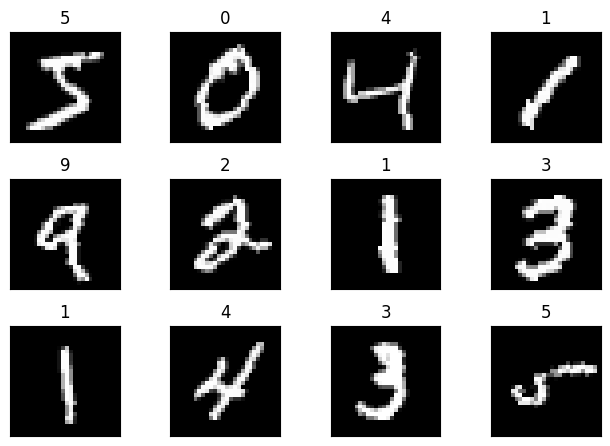

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

### Convolutional Neural Network ( ***models.py*** )

* Convolutional Neural Network is defined in *models.py* file

* We have designed a Convolution Neural Network which consists of 4 2d Convolutional Layers with each having kernel of size 3 with growing channels (i.e 1 -> 32 -> 64 -> 128 -> 256 ) and 2 Fully Connected Layers.

* We have defined 2 max pooling layers which will help reduce size of image.

* We are using activation functioon as relu for all convolutions and softmax function for the final layer to predict probability of presence of each class in the given image to identify the class with max probability that determines the input image.

* Architecture looks like below.
  * Conv2D(32) -> relu -> Conv2D(64) -> MaxPool2D -> relu -> Conv2D(128)  -> relu -> Conv2D(256) -> MaxPool2D -> relu -> squeeze -> FC(50) -> relu -> FC(10) -> softmax
  * Below architecture is designed to work for input images of size 28 * 28.


* set device to cuda if available and load neural network to device
* print model summary for the model

In [9]:
from model import Net
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
nn_model = Net().to(device)
summary(nn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

### Initialize train, test losses , train, test accuracies and incorrect predictions with default values

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

### Define Functions to train and test the model with MNIST data ( ***utils.py*** )

* functions for train, test and plotting graphs to see train, test accuracy and losses of the model are provided in utils.py file.

* Steps followed as part of training model:
  * model.train() - trains model ( sets to training mode )
  * For every batch,
    * load the data and target to device ( cuda)
    * set gradients to zero ([optimizer.zero_grad()](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)) - for every mini batch we set grad to zero before we do back propagation as pytorch accumulates gradients on subsequent backward passes. if not done, then gradients from multiple passes will be accumulated resulting in deviated output.
    * predict output for the batch of data
    * calculate cross entropy loss and sum up training loss
    * do back propagation ( accumulate gradients for each parameters which have *requires_grad* set to true)
    * update weights([for each parameter](https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944))
    * calculate the correct predicted count
    * print the accuracy and train loss for each batch

* Steps followed as part of testing model:
  * model.eval() - set training mode to false, evaluating the model ( i.e model.train(False))
  * torch.no_grad() - disable calculation of gradients for every tensor within the block
  * for every batch,
    * load test data and target to device
    * predict output for the batch of data
    * calculate cross entropy loss and sum up the test loss
    * get the correct outputs for each batch
  * print avg test loss  and accuracy for the test dataset




CODE BLOCK: 10

### Train and test the model for MNIST data

* Define model and utility instances
* load model to device
* define [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd) with model parameters, learning rate as 0.01 and momentum as 0.9
  * SGD: random training example (or a small batch) is selected to calculate the gradient and update the model parameters. This random selection introduces randomness into the optimization process, hence the term “*stochastic*” in stochastic Gradient Descent. This method is computationally less expensive.


* define StepLR scheduler with step size as 15 and gamma as 0.1
  * Scheduler is defined to have adaptive learning rate as per gradient descent procedure.
  * usually suggested to have high learning rate at the beginning so model can explore different dimensions of predictions and then gradually decrease by the time we reach the end.
  * StepLR scheduler is used for gradual learning rate reduction.
* define cross entropy loss function
* for every epoch,
  * train the model and print the train loss and accuracy
  * evaluate model and print the test loss and accuracy
  * use scheduler to decay learning rate by gamma ( which will apply for 15 steps [lr = lr * gamma] )


In [11]:
from model import Net
from utils import Utils
nn_model = Net()
utils = Utils()
torch._nested_tensor_from_mask_left_alignedmodel = nn_model.to(device)
optimizer = optim.SGD(nn_model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  utils.train(nn_model, device, train_loader, optimizer, criterion, train_losses, train_acc)
  utils.test(nn_model, device, test_loader, criterion, test_losses, test_acc)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3949 Batch_id=117 Accuracy=56.28: 100%|██████████| 118/118 [00:30<00:00,  3.88it/s]


Test set: Average loss: 0.1917, Accuracy: 9397/10000 (93.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2935 Batch_id=117 Accuracy=94.23: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]


Test set: Average loss: 0.0887, Accuracy: 9724/10000 (97.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2580 Batch_id=117 Accuracy=96.21: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


Test set: Average loss: 0.0654, Accuracy: 9788/10000 (97.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2120 Batch_id=117 Accuracy=97.05: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0564, Accuracy: 9809/10000 (98.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1934 Batch_id=117 Accuracy=97.43: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0516, Accuracy: 9831/10000 (98.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.2050 Batch_id=117 Accuracy=97.70: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0459, Accuracy: 9853/10000 (98.53%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1957 Batch_id=117 Accuracy=97.91: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s]


Test set: Average loss: 0.0477, Accuracy: 9840/10000 (98.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1416 Batch_id=117 Accuracy=98.14: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s]


Test set: Average loss: 0.0414, Accuracy: 9865/10000 (98.65%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1548 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0350, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1069 Batch_id=117 Accuracy=98.44: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.0302, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0787 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


Test set: Average loss: 0.0293, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1427 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]


Test set: Average loss: 0.0297, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1534 Batch_id=117 Accuracy=98.70: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0291, Accuracy: 9898/10000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1382 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.1547 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:21<00:00,  5.43it/s]


Test set: Average loss: 0.0289, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0674 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.1208 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.1070 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.1141 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:22<00:00,  5.31it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0763 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0219, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

### Visualize how losses and accuracy are changing over epochs


Text(0.5, 1.0, 'Test Accuracy')

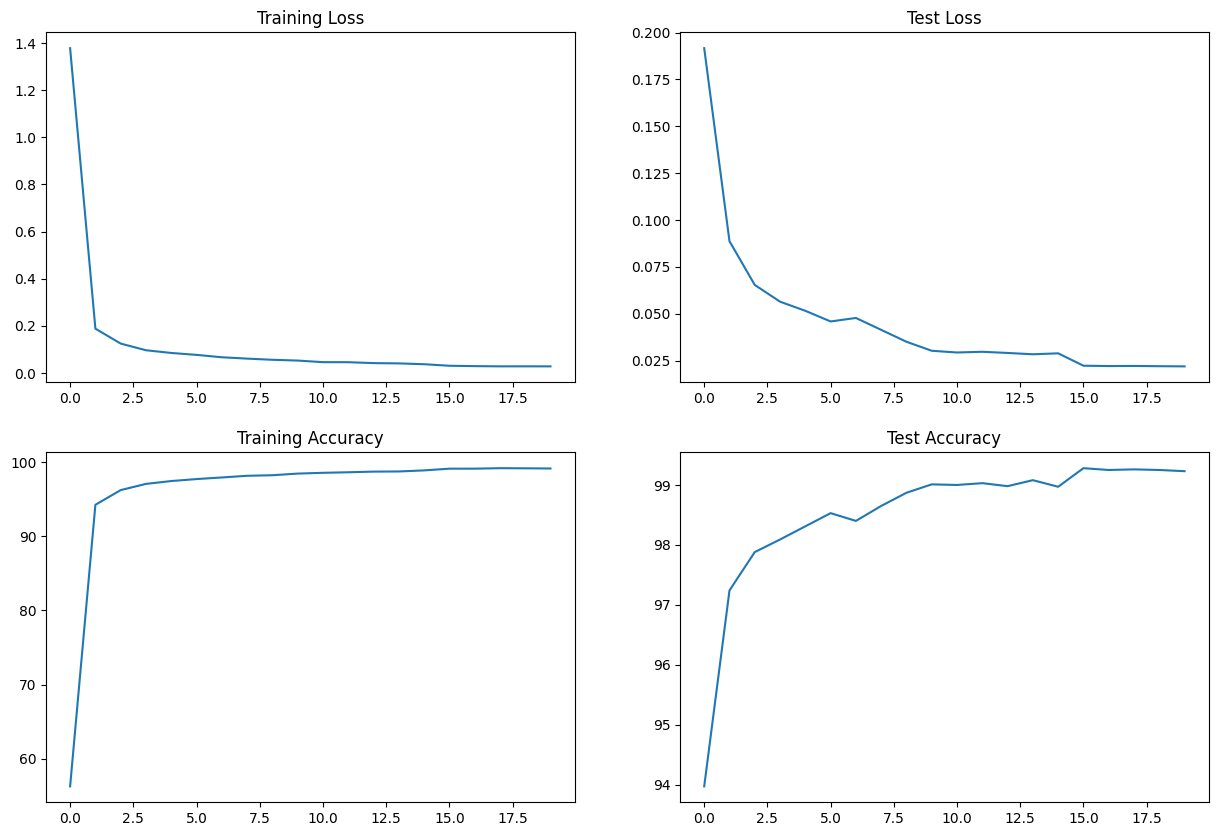

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")